In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, LeakyReLU
from keras import regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas_ta as ta
import time
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import math

In [2]:
df = pd.read_csv(f'data/aapl.csv')

In [3]:
df['RSI']=ta.rsi(df.Close)
df['EMAF']=ta.ema(df.Close)

In [4]:
df = df.dropna()

In [5]:
df

,Date,Open,High,Low,Close,Volume,SPY_close,Scaled_sentiment,RSI,EMAF
14,2022-03-01 08:14:00+00:00,161.5477,161.6165,161.5181,161.5378,7339,413.6735,-0.495467,69.999251,161.397152
15,2022-03-01 08:15:00+00:00,161.5083,161.6067,161.5083,161.6067,6532,413.7689,-0.495467,73.554912,161.435251
16,2022-03-01 08:16:00+00:00,161.5575,161.6362,161.5378,161.6362,4700,413.8833,-0.495467,74.925204,161.471788
17,2022-03-01 08:17:00+00:00,161.5871,161.5969,161.5871,161.5969,3200,413.8738,-0.495467,69.740673,161.494535
18,2022-03-01 08:18:00+00:00,161.5773,161.6362,161.5773,161.6362,11781,413.9692,-0.495467,71.839185,161.520293
...,...,...,...,...,...,...,...,...,...,...
685113,2025-03-21 19:55:00+00:00,217.7400,217.7600,217.7300,217.7600,879,564.8200,0.097823,59.215087,217.721387
685114,2025-03-21 19:56:00+00:00,217.7600,217.7800,217.7500,217.7800,296,564.9000,0.097823,61.585722,217.732044
685115,2025-03-21 19:57:00+00:00,217.7800,217.8100,217.7000,217.8000,2902,565.0000,0.097823,63.848667,217.744400
685116,2025-03-21 19:58:00+00:00,217.8000,217.8800,217.7600,217.8788,2473,565.0900,0.097823,71.077899,217.768836


In [6]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)
#enddef

In [7]:
features = df[['SPY_close','High','Low','Volume','Scaled_sentiment',"RSI","EMAF"]].values
target = df['Close'].values

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 5
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))

[[[2.81892781e-01 2.58172980e-01 2.83669341e-01 3.01751567e-05
   1.86579386e-01 7.03610910e-01 2.82727836e-01]
  [2.82239369e-01 2.58107756e-01 2.83597640e-01 2.68566296e-05
   1.86579386e-01 7.39467258e-01 2.83007245e-01]
  [2.82654985e-01 2.58304093e-01 2.83813475e-01 1.93231209e-05
   1.86579386e-01 7.53285692e-01 2.83275188e-01]
  [2.82620471e-01 2.58042531e-01 2.84174175e-01 1.31548550e-05
   1.86579386e-01 7.01003333e-01 2.83442012e-01]
  [2.82967060e-01 2.58304093e-01 2.84102474e-01 4.84414480e-05
   1.86579386e-01 7.22165355e-01 2.83630906e-01]]

 [[2.82239369e-01 2.58107756e-01 2.83597640e-01 2.68566296e-05
   1.86579386e-01 7.39467258e-01 2.83007245e-01]
  [2.82654985e-01 2.58304093e-01 2.83813475e-01 1.93231209e-05
   1.86579386e-01 7.53285692e-01 2.83275188e-01]
  [2.82620471e-01 2.58042531e-01 2.84174175e-01 1.31548550e-05
   1.86579386e-01 7.01003333e-01 2.83442012e-01]
  [2.82967060e-01 2.58304093e-01 2.84102474e-01 4.84414480e-05
   1.86579386e-01 7.22165355e-01 2.8363

In [8]:
batchSize = 512
epoch = 20
neurons = 100
dropout = 0.3

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

# Dense շերտ (առանց activation)
model.add(Dense(units=64, activity_regularizer=regularizers.l1(0.0001)))
model.add(LeakyReLU(alpha=0.01))

model.add(Dense(1))

model.summary()

start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print("Compilation Time : ", time.time() - start)
history = model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.1)

C:\Users\S145\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\S145\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 100)         │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,529 (822.38 KB)

 Trainable params: 210,529 (822.38 KB)

 Non-trainable params: 0 (0.00 B)

Compilation Time :  0.012782096862792969
Epoch 1/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 62s 60ms/step - loss: 0.0334 - val_loss: 0.0713
Epoch 2/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 58s 60ms/step - loss: 0.0093 - val_loss: 0.0164
Epoch 3/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - loss: 0.0059 - val_loss: 0.0125
Epoch 4/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - loss: 0.0046 - val_loss: 0.0101
Epoch 5/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 59s 62ms/step - loss: 0.0034 - val_loss: 0.0073
Epoch 6/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 59s 61ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 7/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 59s 61ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 8/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 59s 62ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 9/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 59s 61ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 10/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 59s 61ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 11/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 60s 62ms/step - loss: 0.0014 - val_lo

In [9]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

17128/17128 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step
4282/4282 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step


In [10]:
###### --- Train Evaluation ---
train_mse = mean_squared_error(trainYInv[:, 0], trainPredictInv[:, 0])
train_rmse = math.sqrt(train_mse)
train_mae = mean_absolute_error(trainYInv[:, 0], trainPredictInv[:, 0])
train_r2 = r2_score(trainYInv[:, 0], trainPredictInv[:, 0])

print(f"Training MSE: {train_mse:.8f}")
print(f"Training RMSE: {train_rmse:.8f}")
print(f"Training MAE: {train_mae:.8f}")
print(f"Training R²: {train_r2:.8f}")

# --- Test Evaluation ---
test_mse = mean_squared_error(testYInv[:, 0], testPredictInv[:, 0])
test_rmse = math.sqrt(test_mse)
test_mae = mean_absolute_error(testYInv[:, 0], testPredictInv[:, 0])
test_r2 = r2_score(testYInv[:, 0], testPredictInv[:, 0])

print(f"Testing MSE: {test_mse:.8f}")
print(f"Testing RMSE: {test_rmse:.8f}")
print(f"Testing MAE: {test_mae:.8f}")
print(f"Testing R²: {test_r2:.8f}")

Training MSE: 0.26461233
Training RMSE: 0.51440483
Training MAE: 0.39627187
Training R²: 0.99951446
Testing MSE: 2.23165984
Testing RMSE: 1.49387410
Testing MAE: 1.26271208
Testing R²: 0.97964189


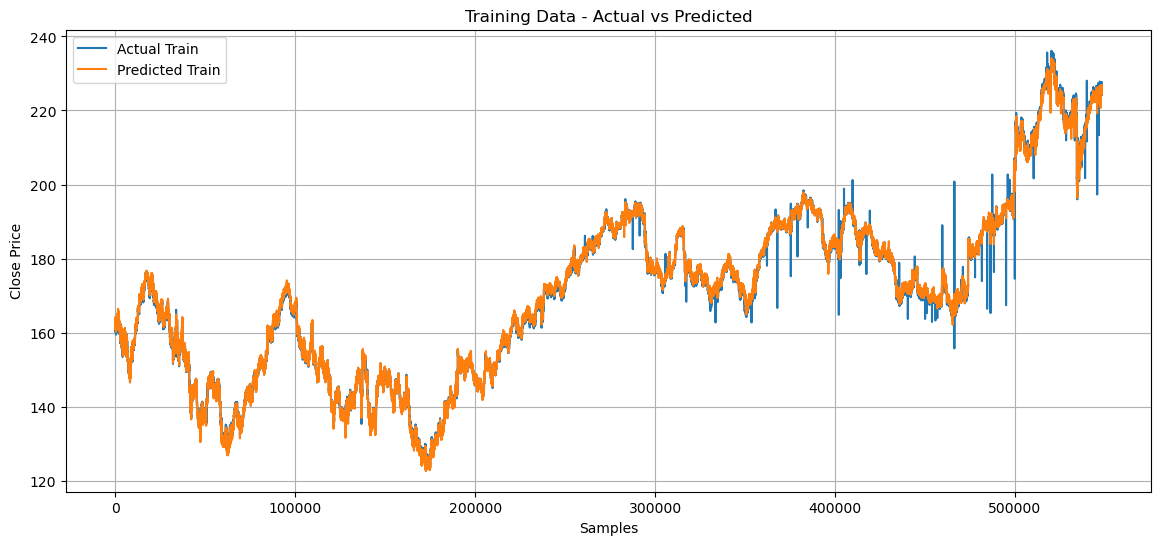

In [11]:
# 📈 Վիզուալիզացիա - Actual vs Predicted
# Training Data
plt.figure(figsize=(14, 6))
plt.plot(trainYInv, label='Actual Train')
plt.plot(trainPredictInv, label='Predicted Train')
plt.title('Training Data - Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

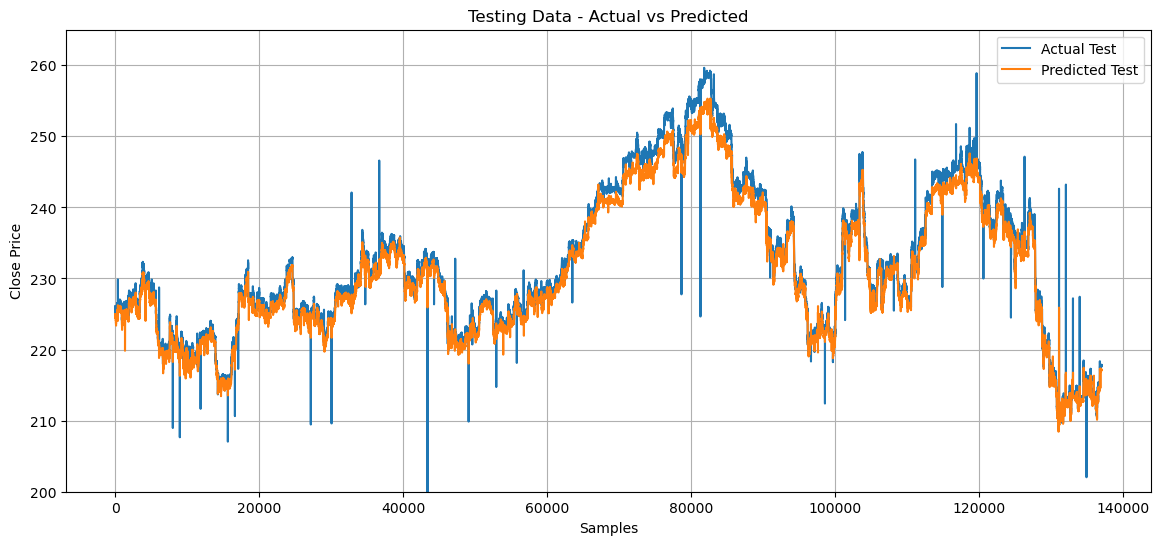

In [12]:
# Testing Data
plt.figure(figsize=(14, 6))
plt.plot(testYInv, label='Actual Test')
plt.plot(testPredictInv, label='Predicted Test')
plt.title('Testing Data - Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.ylim(200, 265)  # Manual control
plt.legend()
plt.grid()
plt.show()

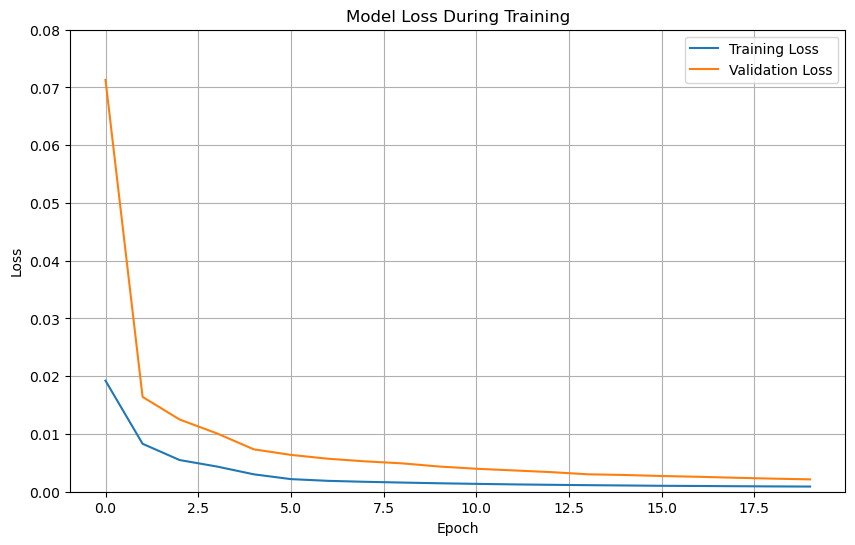

In [13]:
# Ու հետո նկարես loss կորը
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 0.08)  # Manual control
plt.legend()
plt.grid()
plt.show()


In [14]:
import os

results_df = pd.DataFrame({
    'True_Test': testYInv[:, 0],
    'Predicted_Test': testPredictInv[:, 0]
})

save_folder = f"test_result"
os.makedirs(save_folder, exist_ok=True)

save_path1 = os.path.join(save_folder, 'aapl_nonsentiment_LSTM_pred.csv')
results_df.to_csv(save_path1, index=False)
print(f"✅ Test results saved successfully to {save_path1}")

# Step 1: Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'Value': [test_mse, test_rmse, test_mae, test_r2]
})

# Step 4: Define the full save path
save_path2 = os.path.join(save_folder, 'aapl_nonsentiment_LSTM_eval.csv')

# Step 5: Save the DataFrame
metrics_df.to_csv(save_path2, index=False)

print(f"✅ Evaluation metrics saved successfully to {save_path2}")

✅ Test results saved successfully to test_result\aapl_nonsentiment_LSTM_pred.csv
✅ Evaluation metrics saved successfully to test_result\aapl_nonsentiment_LSTM_eval.csv
